In [50]:
import pandas as pd

#Read in full dataset
data = pd.read_csv('data/sentences.csv',
                            sep='\t', 
                            encoding='utf8', 
                            index_col=0,
                            names=['lang','text'])

#Filter by text length
len_cond = [True if 20<=len(s)<=200 else False for s in data['text']]
data = data[len_cond]

#Filter by text language
lang = ['deu', 'eng', 'fra', 'ita', 'por', 'spa']
data = data[data['lang'].isin(lang)]

#Select 50000 rows for each language
data_trim = pd.DataFrame(columns=['lang','text'])

for l in lang:
    lang_trim = data[data['lang'] ==l].sample(50000,random_state = 100)
    data_trim = pd.concat([data_trim, lang_trim])

#Create a random train, valid, test split
data_shuffle = data_trim.sample(frac=1)

train = data_shuffle[0:210000]
valid = data_shuffle[210000:270000]
test = data_shuffle[270000:300000]

In [51]:
from sklearn.feature_extraction.text import CountVectorizer

def get_trigrams(corpus,n_feat=200):
    """
    Returns a list of the N most common character trigrams from a list of sentences
    params
    ------------
        corpus: list of strings
        n_feat: integer
    """
    
    #fit the n-gram model
    vectorizer = CountVectorizer(analyzer='char',
                            ngram_range=(3, 3)
                            ,max_features=n_feat)
    
    X = vectorizer.fit_transform(corpus)
    
    #Get model feature names
    feature_names = vectorizer.get_feature_names_out()
    
    return feature_names

#obtain trigrams from each language
features = {}
features_set = set()

for l in lang:
    
    #get corpus filtered by language
    corpus = train[train.lang==l]['text']
    
    #get 200 most frequent trigrams
    trigrams = get_trigrams(corpus)
    
    #add to dict and set
    features[l] = trigrams 
    features_set.update(trigrams)

    
#create vocabulary list using feature set
vocab = dict()
for i,f in enumerate(features_set):
    vocab[f]=i
    

#train count vectoriser using vocabulary
vectorizer = CountVectorizer(analyzer='char',
                             ngram_range=(3, 3),
                            vocabulary=vocab)

#create feature matrix for training set
corpus = train['text']   
X = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names_out()

train_feat = pd.DataFrame(data=X.toarray(),columns=feature_names)


#Scale feature matrix 
train_min = train_feat.min()
train_max = train_feat.max()
train_feat = (train_feat - train_min)/(train_max-train_min)

#Add target variable 
train_feat['lang'] = list(train['lang'])

#create feature matrix for validation set
corpus = valid['text']   
X = vectorizer.fit_transform(corpus)

valid_feat = pd.DataFrame(data=X.toarray(),columns=feature_names)
valid_feat = (valid_feat - train_min)/(train_max-train_min)
valid_feat['lang'] = list(valid['lang'])

#create feature matrix for test set
corpus = test['text']   
X = vectorizer.fit_transform(corpus)

test_feat = pd.DataFrame(data=X.toarray(),columns=feature_names)
test_feat = (test_feat - train_min)/(train_max-train_min)
test_feat['lang'] = list(test['lang'])

In [53]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

#Fit encoder
encoder = LabelEncoder()
encoder.fit(['deu', 'eng', 'fra', 'ita', 'por', 'spa'])

def encode(y):
    """
    Returns a list of one hot encodings
    Params
    ---------
        y: list of language labels
    """
    
    y_encoded = encoder.transform(y)
    y_dummy = np_utils.to_categorical(y_encoded)
    
    return y_dummy

from keras.models import Sequential
from keras.layers import Dense

#Get training data
x = train_feat.drop('lang',axis=1)
y = encode(train_feat['lang'])


#Define model
model = Sequential()
model.add(Dense(500, input_dim=670, activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(250, activation='relu'))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Train model
model.fit(x, y, epochs=4, batch_size=100)

Epoch 1/4
2100/2100 [==============================] - 10s 5ms/step - loss: 0.0725 - accuracy: 0.9755
Epoch 2/4
2100/2100 [==============================] - 10s 5ms/step - loss: 0.0344 - accuracy: 0.9876
Epoch 3/4
2100/2100 [==============================] - 10s 5ms/step - loss: 0.0213 - accuracy: 0.9923
Epoch 4/4
2100/2100 [==============================] - 10s 5ms/step - loss: 0.0118 - accuracy: 0.9959


938/938 [==============================] - 1s 1ms/step
0.9867


Text(86.25, 0.5, 'Actual')

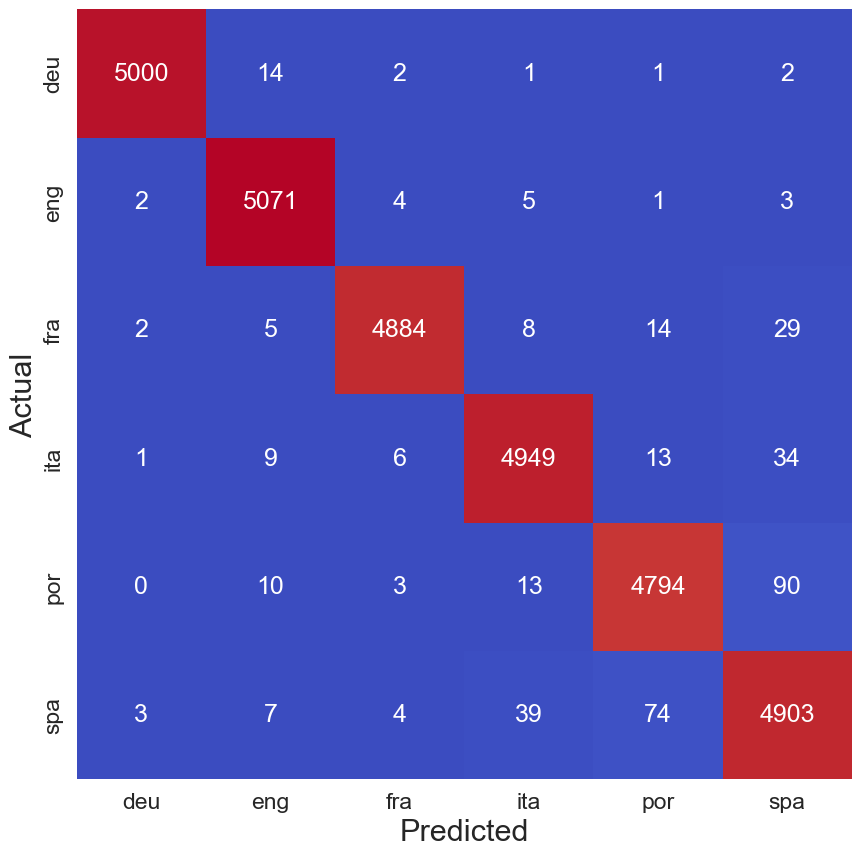

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score,confusion_matrix

x_test = test_feat.drop('lang',axis=1)
y_test = test_feat['lang']


y_pred = model.predict(x_test)
#Get pred ictions on test set
labels = np.argmax(y_pred, axis=1)
predictions = encoder.inverse_transform(labels)

#Accuracy on test set
accuracy = accuracy_score(y_test,predictions)
print(accuracy)

#Create confusion matrix
lang = ['deu', 'eng', 'fra', 'ita', 'por', 'spa']
conf_matrix = confusion_matrix(y_test,predictions)
conf_matrix_df = pd.DataFrame(conf_matrix,columns=lang,index=lang)

#Plot confusion matrix heatmap
plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
sns.set(font_scale=1.5)
sns.heatmap(conf_matrix_df,cmap='coolwarm',annot=True,fmt='.5g',cbar=False)
plt.xlabel('Predicted',fontsize=22)
plt.ylabel('Actual',fontsize=22)

In [ ]:
# Get the input text
input_text = input("Enter a in one of these languages (deu, eng, fra, ita, por, spa): ")

# Convert the input text into a feature vector
input_vector = vectorizer.transform([input_text])

# Reshape the input vector
input_vector = input_vector.reshape(1, -1)

# Scale the input feature vector
train_min = np.array(train_min)
train_max = np.array(train_max)
input_vector = (input_vector - train_min)/(train_max-train_min)

# Make a prediction on the input feature vector
input_prediction = model.predict(input_vector)

# Get the predicted label
input_label = encoder.inverse_transform(np.argmax(input_prediction, axis=1))

# Print the predicted label
print(f"The input text is in {input_label[0]}")
